/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_root.py:245: RuntimeWarning: Method krylov does not use the jacobian (jac).
  _warn_jac_unused(jac, method)


[-1.72372434e-34  4.23516474e-22  2.16840434e-19  0.00000000e+00]
[ 2.45187027e-27 -1.27054942e-21  2.16840434e-19  0.00000000e+00]
[-1.78836878e-35  1.27054942e-21  0.00000000e+00  0.00000000e+00]
[1.26589582e-27 2.96461532e-21 2.16840434e-19 0.00000000e+00]
[-1.11869208e-34 -8.47032947e-22  2.16840434e-19 -6.77626358e-21]
[5.09871995e-37 1.69406589e-21 2.16840434e-19 6.77626358e-21]
[ 9.85769007e-37 -8.47032947e-22 -4.33680869e-19 -1.35525272e-20]
[-6.88642006e-39 -8.47032947e-22  0.00000000e+00  0.00000000e+00]
[-2.93477210e-35 -1.69406589e-21 -2.16840434e-19  0.00000000e+00]
[-2.14335816e-37  8.47032947e-22 -2.16840434e-19  0.00000000e+00]
[5.46636928e-37 0.00000000e+00 2.16840434e-19 0.00000000e+00]
[ 3.51175193e-28  3.38813179e-21 -2.16840434e-19 -1.35525272e-20]
[-1.61646674e-35  0.00000000e+00  0.00000000e+00  0.00000000e+00]
[-4.08472518e-35 -1.69406589e-21 -4.33680869e-19  0.00000000e+00]
[ 4.28803220e-37  8.47032947e-21 -2.16840434e-19  0.00000000e+00]
[ 5.61356181e-36  1.01

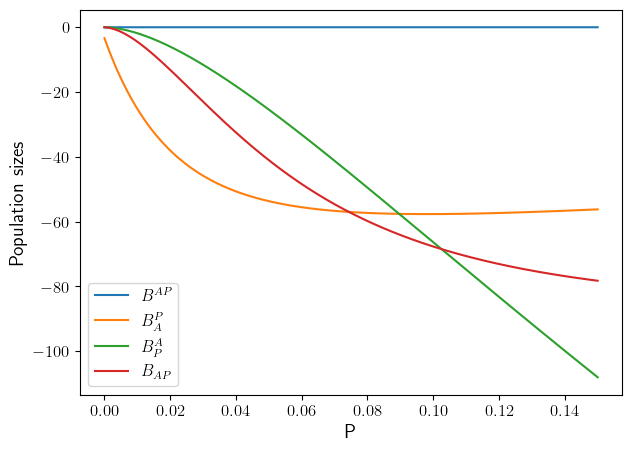

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

plt.rcParams["text.usetex"] = True

# Assume all your parameters and A, CC, etc. are already defined before

rho1 = 0.1
rho2 = 1e-1
rho3 = 1e-1
rho4 = 1e-1

alpha1 = 0.1
alpha2 = 0.2
alpha3 = 0.1
delta2 = 1e-2

beta1 = 0.4
beta2 = 0.2
beta3 = 0.3
gamma = 1e-1
nu = 0.4

CC = 0.887
A = 0.05
burstsize = 180

S = CC * (1 - (alpha1 * A / rho1))
numerator = alpha1 * A * S
denominator = delta2 * (A / (1 + A)) + alpha1 * A * (1 - (rho2 / rho1))
x2 = numerator / denominator
x1 = S - x2

def f_fixedP(y, P_fixed):
    B1, B2, B3, B4 = y
    BA = B1 + B2 + B3 + B4

    dB1 = rho1 * B1 * (1 - BA / CC) - alpha1 * A * B1 - beta1 * P_fixed * B1
    dB2 = rho3 * B2 * (1 - BA / CC) + beta1 * P_fixed * B1 - alpha2 * A * B2 + beta2 * P_fixed * B3 - gamma * (P_fixed / (1 + P_fixed)) * B2 - alpha3 * A * B2
    dB3 = rho2 * B3 * (1 - BA / CC) + alpha1 * A * B1 + alpha2 * A * B2 - beta2 * P_fixed * B3 - beta3 * P_fixed * B3 - delta2 * (A / (1 + A)) * B3
    dB4 = rho4 * B4 * (1 - BA / CC) + alpha3 * A * B2 + beta3 * P_fixed * B3 - nu * ((P_fixed + A) / (1 + P_fixed + A)) * B4

#    dB1 = max(dB1, 0)
#    dB2 = max(dB2, 0)
#    dB3 = max(dB3, 0)
#    dB4 = max(dB4, 0)
    return np.array([dB1, dB2, dB3, dB4])

def jacobian_fixedP(y, P_fixed):
    B1, B2, B3, B4 = y
    BA = B1 + B2 + B3 + B4

    J = np.zeros((4, 4))  # 4x4 Jacobian because P is fixed

    # Partial derivatives for dB1
    J[0, 0] = rho1 * (1 - BA / CC) - rho1 * B1 / CC - alpha1 * A - beta1 * P_fixed
    J[0, 1] = -rho1 * B1 / CC
    J[0, 2] = -rho1 * B1 / CC
    J[0, 3] = -rho1 * B1 / CC

    # Partial derivatives for dB2
    J[1, 0] = beta1 * P_fixed - rho3 * B2 / CC
    J[1, 1] = rho3 * (1 - BA / CC) - rho3 * B2 / CC - alpha2 * A - alpha3 * A - gamma * (P_fixed / (1 + P_fixed))
    J[1, 2] = beta2 * P_fixed - rho3 * B2 / CC
    J[1, 3] = -rho3 * B2 / CC

    # Partial derivatives for dB3
    J[2, 0] = alpha1 * A - rho2 * B3 / CC
    J[2, 1] = alpha2 * A - rho2 * B3 / CC
    J[2, 2] = rho2 * (1 - BA / CC) - rho2 * B3 / CC - beta2 * P_fixed - beta3 * P_fixed - delta2 * (A / (1 + A))
    J[2, 3] = -rho2 * B3 / CC

    # Partial derivatives for dB4
    J[3, 0] = -rho4 * B4 / CC
    J[3, 1] = alpha3 * A - rho4 * B4 / CC
    J[3, 2] = beta3 * P_fixed - rho4 * B4 / CC
    J[3, 3] = rho4 * (1 - BA / CC) - rho4 * B4 / CC - nu * ((P_fixed + A) / (1 + P_fixed + A))

    return J

# CONTINUATION
P_vals = np.linspace(1e-5, 0.15, 30000)  # Pe axis
B1_list = []
B2_list = []
B3_list = []
B4_list = []

S = CC * (1 - (alpha1 * A / rho1))
numerator = alpha1 * A * S
denominator = delta2 * (A / (1 + A)) + alpha1 * A * (1 - (rho2 / rho1))
x2 = numerator / denominator
x1 = S - x2
B_A = CC * ((-delta2 / rho2) * (A / (1 + A)) + 1)

# Initial guess
y_guess = [1e-5, B_A, 1e-5, 1e-5]

for i, P_fixed in enumerate(P_vals):
    func = lambda y: f_fixedP(y, P_fixed)
    jac = lambda y: jacobian_fixedP(y, P_fixed)

    try:
        J_eval = jac(y_guess)
        if np.abs(np.linalg.det(J_eval)) < 1e-13:
            print(f"WARNING: Jacobian is near singular at step {i}, P = {P_fixed:.5f}")
    except np.linalg.LinAlgError:
        print(f"ERROR: Jacobian not invertible at step {i}, P = {P_fixed:.5f}")
        continue

    sol = optimize.root(func, y_guess, jac=jac, tol=1e-12, method='krylov')

    if sol.success:
        y_sol = sol.x
        print(func(y_sol))  # <-- Only called after y_sol is safely defined
        B1_list.append(y_sol[0])
        B2_list.append(y_sol[1])
        B3_list.append(y_sol[2])
        B4_list.append(y_sol[3])
        y_guess = y_sol
    else:
        print(f"WARNING: Newton did not converge at step {i}, P = {P_fixed:.5f}")
        B1_list.append(np.nan)
        B2_list.append(np.nan)
        B3_list.append(np.nan)
        B4_list.append(np.nan)



# PLOTTING
# PLOTTING
plt.figure(figsize=(7,5))
plt.plot(P_vals, B1_list, label=r'$B^{AP}$')
plt.plot(P_vals, B3_list, label=r'$B^{P}_{A}$')
plt.plot(P_vals, B2_list, label=r'$B^{A}_{P}$')
plt.plot(P_vals, B4_list, label=r'$B_{AP}$')
plt.xlabel('P', fontsize=14)
plt.ylabel('Population sizes', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.title('Continuation: Equilibria vs P')
plt.legend(fontsize=12)
#plt.grid()
plt.savefig('continuation_rf.pdf')
plt.show()



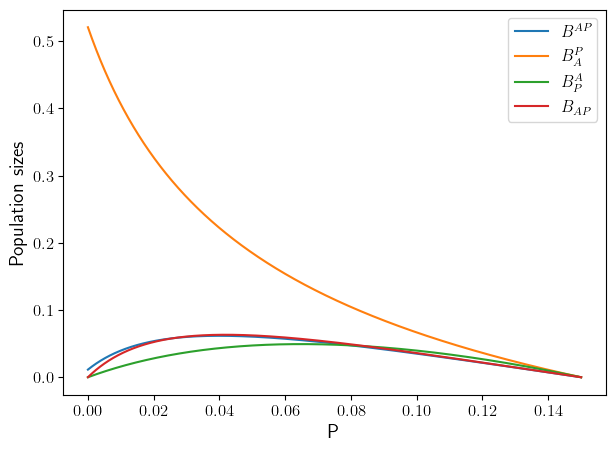

In [24]:
# PLOTTING
plt.figure(figsize=(7,5))
plt.plot(P_vals, B1_list, label=r'$B^{AP}$')
plt.plot(P_vals, B3_list, label=r'$B^{P}_{A}$')
plt.plot(P_vals, B2_list, label=r'$B^{A}_{P}$')
plt.plot(P_vals, B4_list, label=r'$B_{AP}$')
plt.xlabel('P', fontsize=14)
plt.ylabel('Population sizes', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.title('Continuation: Equilibria vs P')
plt.legend(fontsize=12)
#plt.grid()
plt.savefig('continuation_coexistence.pdf')
plt.show()

[-2.37692270e-27 -2.96134630e+03 -1.54286588e+03 -2.14505476e+03]
[-1.98781248e-19  1.17654865e-05 -2.94157417e-05  1.76452059e-05]
[-1.10651845e-27  1.17309104e-05 -2.93427835e-05  1.75732468e-05]
[-1.46943273e-27  1.16964498e-05 -2.92700761e-05  1.75015726e-05]
[-1.65051258e-28  1.16621042e-05 -2.91976184e-05  1.74301819e-05]
[-2.19004649e-28  1.16278732e-05 -2.91254093e-05  1.73590735e-05]
[ 1.69410693e-27  1.15937561e-05 -2.90534477e-05  1.72882462e-05]
[-7.55835856e-28  1.15597525e-05 -2.89817326e-05  1.72176987e-05]
[-2.19506244e-27  1.15258620e-05 -2.89102628e-05  1.71474298e-05]
[-2.94324307e-28  1.14920839e-05 -2.88390374e-05  1.70774382e-05]
[-1.04766013e-27  1.14584179e-05 -2.87680553e-05  1.70077227e-05]
[-1.12675561e-27  1.14248635e-05 -2.86973155e-05  1.69382822e-05]
[-5.30091486e-28  1.13914201e-05 -2.86268168e-05  1.68691154e-05]
[ 1.60903750e-28  1.13580873e-05 -2.85565584e-05  1.68002211e-05]
[ 3.88437665e-27  1.13248646e-05 -2.84865391e-05  1.67315981e-05]
[ 5.678611

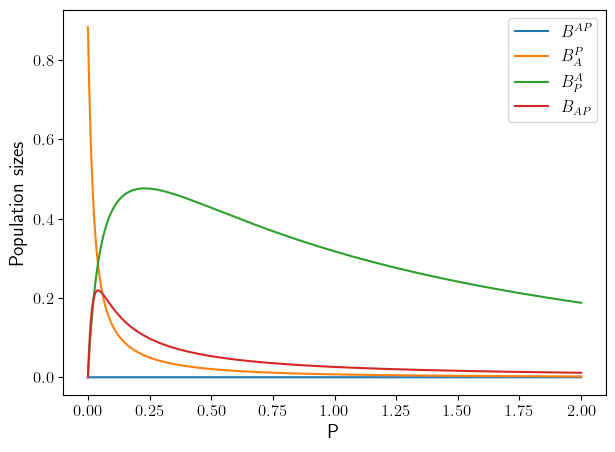

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize


rho1 = 0.1
rho2 = 1e-1
rho3 = 1e-1
rho4 = 1e-1

alpha1 = 0.1
alpha2 = 0.2
alpha3 = 0.1
delta2 = 1e-2

beta1 = 0.4
beta2 = 0.2
beta3 = 0.3
gamma = 1e-1
nu = 0.4

CC = 0.887
A = 0.05
burstsize = 180
# Assume all your parameters and A, CC, etc. are already defined before

def f_fixedP(y, P_fixed):
    B1, B2, B3, B4 = y
    BA = B1 + B2 + B3 + B4

    dB1 = rho1 * B1 * (1 - BA / CC) - alpha1 * A * B1 - beta1 * P_fixed * B1
    dB2 = rho3 * B2 * (1 - BA / CC) + beta1 * P_fixed * B1 - alpha2 * A * B2 + beta2 * P_fixed * B3 - gamma * (P_fixed / (1 + P_fixed)) * B2 - alpha3 * A * B2
    dB3 = rho2 * B3 * (1 - BA / CC) + alpha1 * A * B1 + alpha2 * A * B2 - beta2 * P_fixed * B3 - beta3 * P_fixed * B3 - delta2 * (A / (1 + A)) * B3
    dB4 = rho4 * B4 * (1 - BA / CC) + alpha3 * A * B2 + beta3 * P_fixed * B3 - nu * ((P_fixed + A) / (1 + P_fixed + A)) * B4

#    dB1 = max(dB1, 0)
#    dB2 = max(dB2, 0)
#    dB3 = max(dB3, 0)
#    dB4 = max(dB4, 0)
    return np.array([dB1, dB2, dB3, dB4])

def jacobian_fixedP(y, P_fixed):
    B1, B2, B3, B4 = y
    BA = B1 + B2 + B3 + B4

    J = np.zeros((4, 4))  # 4x4 Jacobian because P is fixed

    # Partial derivatives for dB1
    J[0, 0] = rho1 * (1 - BA / CC) - rho1 * B1 / CC - alpha1 * A - beta1 * P_fixed
    J[0, 1] = -rho1 * B1 / CC
    J[0, 2] = -rho1 * B1 / CC
    J[0, 3] = -rho1 * B1 / CC

    # Partial derivatives for dB2
    J[1, 0] = beta1 * P_fixed - rho3 * B2 / CC
    J[1, 1] = rho3 * (1 - BA / CC) - rho3 * B2 / CC - alpha2 * A - alpha3 * A - gamma * (P_fixed / (1 + P_fixed))
    J[1, 2] = beta2 * P_fixed - rho3 * B2 / CC
    J[1, 3] = -rho3 * B2 / CC

    # Partial derivatives for dB3
    J[2, 0] = alpha1 * A - rho2 * B3 / CC
    J[2, 1] = alpha2 * A - rho2 * B3 / CC
    J[2, 2] = rho2 * (1 - BA / CC) - rho2 * B3 / CC - beta2 * P_fixed - beta3 * P_fixed - delta2 * (A / (1 + A))
    J[2, 3] = -rho2 * B3 / CC

    # Partial derivatives for dB4
    J[3, 0] = -rho4 * B4 / CC
    J[3, 1] = alpha3 * A - rho4 * B4 / CC
    J[3, 2] = beta3 * P_fixed - rho4 * B4 / CC
    J[3, 3] = rho4 * (1 - BA / CC) - rho4 * B4 / CC - nu * ((P_fixed + A) / (1 + P_fixed + A))

    return J

# CONTINUATION
P_vals = np.linspace(1e-5, 2, 30000)  # Pe axis
B1_list = []
B2_list = []
B3_list = []
B4_list = []

B_A = CC * ((-delta2 / rho2) * (A / (1 + A)) + 1)
# Initial guess
y_guess = [1e-5, 1e-5, B_A, 1e-5]

for i, P_fixed in enumerate(P_vals):
    func = lambda y: f_fixedP(y, P_fixed)
    jac = lambda y: jacobian_fixedP(y, P_fixed)
   # Evaluate Jacobian at current guess
    try:
        J_eval = jac(y_guess)  # evaluate Jacobian at current y_guess
        if np.abs(np.linalg.det(J_eval)) < 1e-13:
            print(f"WARNING: Jacobian is near singular at step {i}, P = {P_fixed:.5f}")
    except np.linalg.LinAlgError:
        print(f"ERROR: Jacobian not invertible at step {i}, P = {P_fixed:.5f}")
    sol = optimize.root(func, y_guess, jac=jac, tol=1e-12)
    print(func(y_sol))

    if sol.success:
        y_sol = sol.x
        B1_list.append(y_sol[0])
        B2_list.append(y_sol[1])
        B3_list.append(y_sol[2])
        B4_list.append(y_sol[3])
        y_guess = y_sol  # Update guess for next step
    else:
        print(f"WARNING: Newton did not converge at step {i}, P = {P_fixed:.5f}")
        B1_list.append(np.nan)
        B2_list.append(np.nan)
        B3_list.append(np.nan)
        B4_list.append(np.nan)
        # Keep old guess


# PLOTTING
plt.figure(figsize=(7,5))
plt.plot(P_vals, B1_list, label=r'$B^{AP}$')
plt.plot(P_vals, B3_list, label=r'$B^{P}_{A}$')
plt.plot(P_vals, B2_list, label=r'$B^{A}_{P}$')
plt.plot(P_vals, B4_list, label=r'$B_{AP}$')
plt.xlabel('P', fontsize=14)
plt.ylabel('Population sizes', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.title('Continuation: Equilibria vs P')
plt.legend(fontsize=12)
#plt.grid()
plt.savefig('continuation_rf.pdf')
plt.show()
